# Imports and definitions

In [1]:
from XRDXRFutils.notebook_utils import *
from paths_and_parameters import *

paths_to_create_delete = [path_figures]


### Utility functions ###

def Dy_from_Da(Da, beta):
    return Da / sin(deg2rad(beta))

def Dz_from_Da(Da, i, beta):
    return Da * sin(deg2rad(i)) / sin(deg2rad(beta))

#### To reset results, delete output folders.
WARNING: every previous result will be lost. Use only if you want to delete all files in the data folders

In [2]:
do_you_want_to_delete = True

if do_you_want_to_delete:
    for path_sel in paths_to_create_delete:
        if isdir(path_sel):
            rmtree(path_sel)

#### Check if output folders exist. If not, create them.

In [3]:
for path_sel in paths_to_create_delete:
    if not isdir(path_sel):
        makedirs(path_sel)

# Read phase database

In [4]:
print('Reading phases from: ' + ', '.join(["'" + path + "'" for path in list_path_database]))
database = DatabaseXRD()
for path_database in list_path_database:
    database.read_cifs(path_database)
print(f'Total number of phases: {len(database)}')

Reading phases from: '../../shared/Database/'
Total number of phases: 369


# Read XRD data
To recalculate h5 file, change just for one time the filename that the cell tries to read (indicated by the comment)

In [6]:
try:
    data = DataXRD().load_h5(path_xrd + 'xrd.h5') # to force the recalculation of h5 file, change this filename
    if any(not hasattr(data, attr) for attr in data.check_attributes):
        print('The present h5 file doesn\'t have all required information. Reading from raw data.')
        data = read_raw_XRD(path_xrd)
except:
    print('Reading from raw data.')
    data = read_raw_XRD(path_xrd)

data.rotate(steps_rotation_xrd)
y_x_ratio = data.shape[0] / data.shape[1]
print('\nShape of data\n-------------')
print(f'x: {data.shape[1]}, y: {data.shape[0]}, channels: {data.shape[2]}')
print('\nInitial calibration\n-------------------')
print(f'a = {data.opt[0]:.1f}, s = {data.opt[1]:.1f}, beta = {data.opt[2]:.3f}')
print(f'Theta range: {list(data.fce_calibration([0, data.shape[2]], *data.opt))}')

Loading: ../../shared/dataXRDXRF/MunchMuseum/M0795/CappelloGialloXRD/xrd.h5

Shape of data
-------------
x: 160, y: 150, channels: 1280

Initial calibration
-------------------
a = -1214.7, s = 1952.7, beta = 51.663
Theta range: [19.77907409195316, 53.578190561278404]


### Correct burnt pixels
Substitute burnt pixel with the average of the non burnt ones.

In [7]:
qtl = 0.9997

data.correct_quantile_pixels(qtl)

8 pixels out of 24000 were corrected.


# Read XRF element maps

If the orientation of tiff images does not correspond with XRD scans, flip them in this cell

In [8]:
data_xrf_elements = DataXRF().read_tiff(path_xrf_elements).flip(axis = xrf_axes_flip).rotate(steps_rotation_xrf_elements)
y_x_ratio = data_xrf_elements.labels.shape[0] / data_xrf_elements.labels.shape[1]
print(f'Found {data_xrf_elements.labels.shape[2]} images: ' + ', '.join([name for name in data_xrf_elements.metadata['labels']]))
print('\nShape of XRF element maps\n-------------------------')
print(f'x: {data_xrf_elements.labels.shape[1]}, y: {data_xrf_elements.labels.shape[0]}')

Found 20 images: As-K, Ba-L, Ca-K, Cd-L, Cl-K, Co-K, Cr-K, Cu-Ka, Cu-Kb, Fe-K, Hg-L, Hg-M, K-K, Mn-K, Pb-L, Pb-M, S-K, Sr-K, Ti-K, data

Shape of XRF element maps
-------------------------
x: 160, y: 150


### Correct burnt pixels and wrong scale in each element map; also calculate normalized element maps
Choose a quantile on the value of XRF intensity. All pixels above that quantile will be corrected as burnt pixels and will be assigned the threshold value.

In [9]:
#qtl = 0.995

#data_xrf_elements.map_correct_specific_pixels([(0, 0)])
data_xrf_elements.map_correct_quantile_pixels(qtl).map_correct_scale()

maps_xrf_norm = data_xrf_elements.labels / data_xrf_elements.labels.max(axis = (0, 1), keepdims = True)

8 pixels out of 24000 were corrected on average in each XRF map.


# Select primary phases

### Manually select them

In [10]:
hydrocerussite = database['Hydrocerussite'][0].select_peaks([]) #[i for i in range(15) if i != 3]
cinnabar = database['Cinnabar'][2].select_peaks([])
gold = database['Gold'][10].select_peaks([])
lead_tin_y = database['Lead-tin yellow'][0].select_peaks([])
lazurite = database['Lazurite'][0].select_peaks([])
barite = database['Baryte'][0].select_peaks([])
#arsenolite = database['Arsenolite'][0].select_peaks([])
#strontium_y = database['Sr2 (Cr O4)'][0]

#phases_primary = [hydrocerussite, gold, cinnabar, lead_tin_y] # Angelo
#phases_primary = [hydrocerussite, cinnabar, lazurite] # Profilo
phases_primary = [hydrocerussite, barite, cinnabar] # Cappello giallo

### Take them from file `phases_selection_primary.dat`

In [11]:
#phases_primary = phases_from_file(subfolder_output + 'phases_selection_primary.dat', database)

### Set parameters of synthetic XRD patterns
You can skip this cell and keep the preset values of the parameters.

In [12]:
#min_theta = 20
#max_theta = 53
#min_intensity = 0.1    # among the tabulated peaks, selects only the ones above this threshold of intensity (scale between 0 and 1)
#first_n_peaks = None   # selects the first n most intense peaks (if None, leaves all the peaks)
#sigma = 0.2            # sigma used in the peaks of synthetic diffraction patterns
#distance_merge = sigma   # Distance under which peaks are merged in each phase. Put None to avoid merging.

### Check the number of tabulated peaks given by chosen parameters

In [13]:
df_phases = DataFrame(columns = ['Phase', 'N. of selected peaks'])
for i, p in enumerate(phases_primary):
    df_phases.loc[i] = [p.label, len(p.get_theta(min_theta = min_theta, max_theta = max_theta, min_intensity = min_intensity,
                                                 first_n_peaks = first_n_peaks, distance_merge = distance_merge)[0])]
df_phases

,Phase,N. of selected peaks
0,Hydrocerussite,10
1,Baryte,16
2,Cinnabar,7


# Search for primary phases

### Process experimental XRD pattern

In [13]:
window_snip = 32        # width of the window used for determining the background (default 32)
offset_background = 15  # value added to the background, before subtracting it from the raw signal (default 0)
std_smooth = 3          # degree of the final smooth applied to the XRD pattern (standard deviation of the Gaussian kernel used in the convolution)

data = data.remove_background(window_snip = window_snip, offset_background = offset_background).smooth_channels(std_smooth)

Removing background...


/Users/dariozappala/.local/lib/python3.10/site-packages/XRDXRFutils/data.py:131: RuntimeWarning: invalid value encountered in divide
  self.intensity = self.data_no_bg / self.rescaling


Done.
Smoothing along channels...
Done.


/Users/dariozappala/.local/lib/python3.10/site-packages/XRDXRFutils/data.py:140: RuntimeWarning: invalid value encountered in divide
  self.intensity = data_smoothed / nanmax(data_smoothed, axis = 2, keepdims = True)


### Change initial calibration

In [14]:
#data.opt = array([-1208.08149362, 1948.24846333, 51.66346438])

### Autocalibration and search
Optimizes on $a,s$ and $\gamma$. Choses the best phase by overlap area and fits with respect to that.

In [15]:
%%time

phase_presence_method = 'adjustment_ratio'
# 'overlap_area', 'overlap_area_ratio', 'adjustment_ratio'

gm = GammaMap().from_data(data, phases_primary, sigma = sigma, min_theta = min_theta, max_theta = max_theta,
    min_intensity = min_intensity, first_n_peaks = first_n_peaks, distance_merge = distance_merge)
gm = gm.search(method = phase_presence_method)

Using 8 CPUs
CPU times: user 18.8 s, sys: 2.66 s, total: 21.5 s
Wall time: 39.8 s


#### Fast mapping

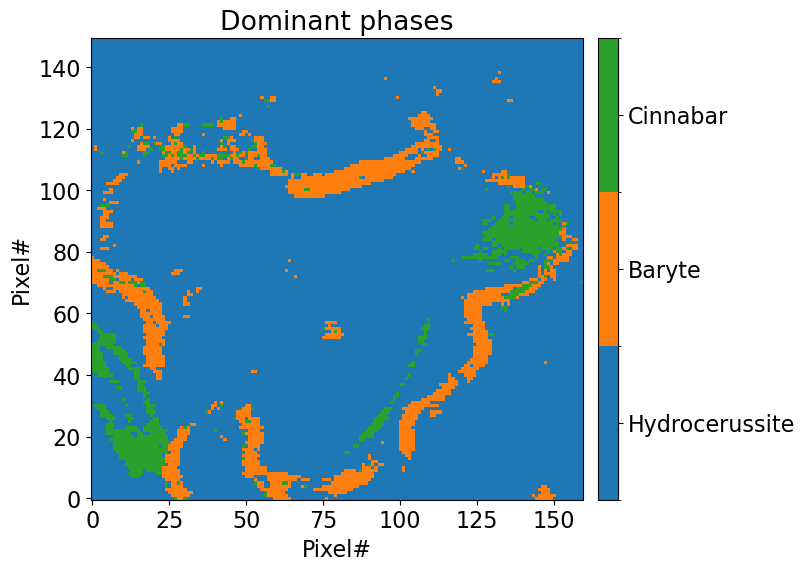

In [16]:
%matplotlib inline
rcParams['font.size'] = 16

fig, ax = subplots(figsize = (10, 6))
cmap_chosen = get_cmap('tab10')
norm_chosen = BoundaryNorm(arange(-0.5, len(gm.phases) + 0.5, 1), len(gm.phases))
im = imshow(gm.selected(), interpolation = 'none', cmap = cmap_chosen, norm = norm_chosen)
cbar = colorbar(im, ax = ax, cax = ax.inset_axes([1.03, 0, 0.04, 1]))
cbar.set_ticks(range(0, len(gm.phases)))
cbar.set_ticklabels([p.label for p in gm.phases])
ax.set_title('Dominant phases')
ax.set_xlabel(r'Pixel#')
ax.set_ylabel(r'Pixel#')

savefig(path_figures + 'fast_map_dominant_phases.png', bbox_inches = 'tight', dpi = 200)
show()

### Quantify phase presence

In [17]:
%%time

phase_presence_method = 'adjustment_ratio'
phase_presence_correction = False
# ('overlap_area', True), ('overlap_area_ratio', False), ('adjustment_ratio', False)

phase_presence = gm.phase_presence(method = phase_presence_method, correction = phase_presence_correction)

Using 8 CPUs
CPU times: user 5.84 s, sys: 898 ms, total: 6.74 s
Wall time: 7.73 s


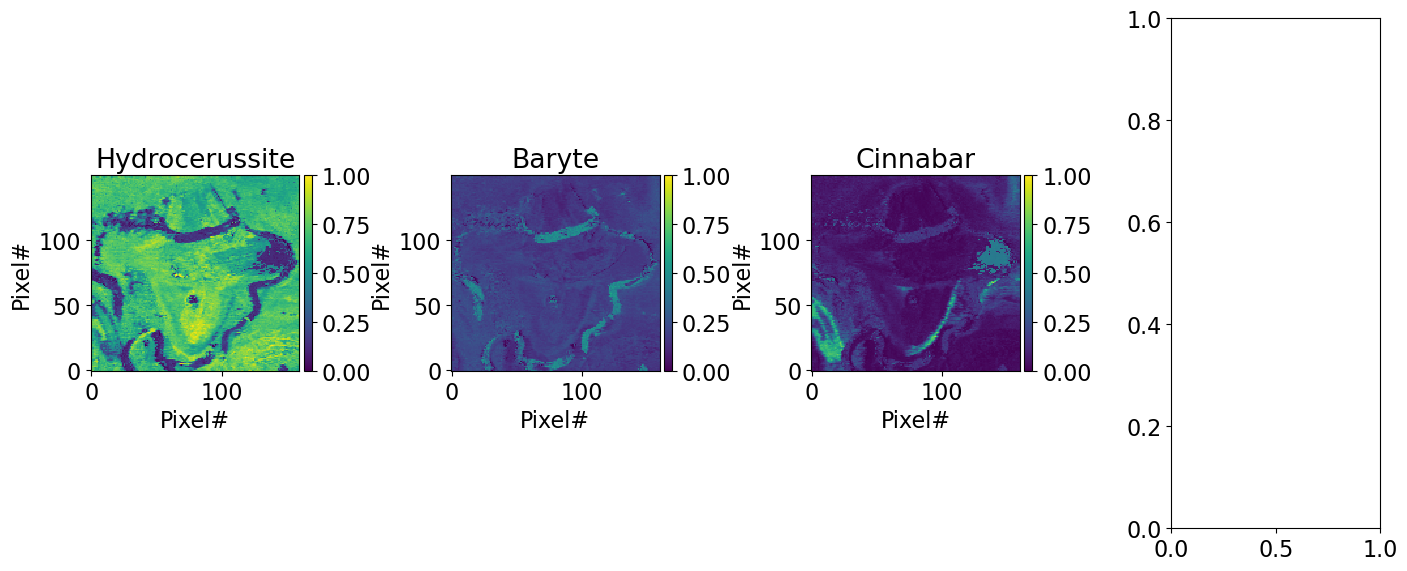

In [18]:
%matplotlib inline
n_of_columns = 4
rcParams['font.size'] = 16

set_nan_as_0 = True

###

n_of_pictures = len(gm.phases)
n_of_rows = n_of_pictures // n_of_columns
if (n_of_pictures % n_of_columns):
    n_of_rows += 1

fig, axs = subplots(n_of_rows, n_of_columns, figsize = (3.5 * n_of_columns, 6 * n_of_rows))
fig.tight_layout(h_pad = 5, w_pad = 4)
cmap_viridis = get_cmap('viridis').copy()
cmap_viridis.set_bad(color = 'grey')
for i, phase in enumerate(gm.phases):
    i_row = i // n_of_columns
    i_column = i % n_of_columns
    if n_of_rows == 1:
        ax = axs[i_column]
    else:
        ax = axs[i_row, i_column]

    matrix_plot = phase_presence[..., i] / nanmax(phase_presence)
    #matrix_plot = phase_presence[..., i] / nanmax(phase_presence[..., i])
    if set_nan_as_0:
        matrix_plot[isnan(matrix_plot)] = 0
    im = ax.imshow(matrix_plot, interpolation = 'none', cmap = cmap_viridis, vmin = 0, vmax = 1)
    colorbar(im, ax = ax, cax = ax.inset_axes([1.02, 0, 0.04, 1]))
    ax.set_title(phase.label)
    ax.set_xlabel(r'Pixel#')
    ax.set_ylabel(r'Pixel#')

show()

# Select phases, area and thresholds for analysis

### Phases
You need to choose phases among the primary ones.
- `phase_reference`: This phase will be used to take a reference calibration.
- `phase_analysis`: The calibration of this phase will be analised.

In [28]:
phase_reference = barite
phase_analysis = hydrocerussite

# Phase presence
phases_sel = [phase_reference, phase_analysis]
presence_phases_sel = []
for i in [0, 1]:
    idx = gm.phases.index(phases_sel[i])
    presence_phases_sel.append(phase_presence[..., idx] / nanmax(phase_presence[..., idx]))
presence_phases_sel = array(presence_phases_sel)

### Area
Choose an area. The analysis will be limited to that area. You may also choose the entire scan.

Area: 160 * 150 = 24000


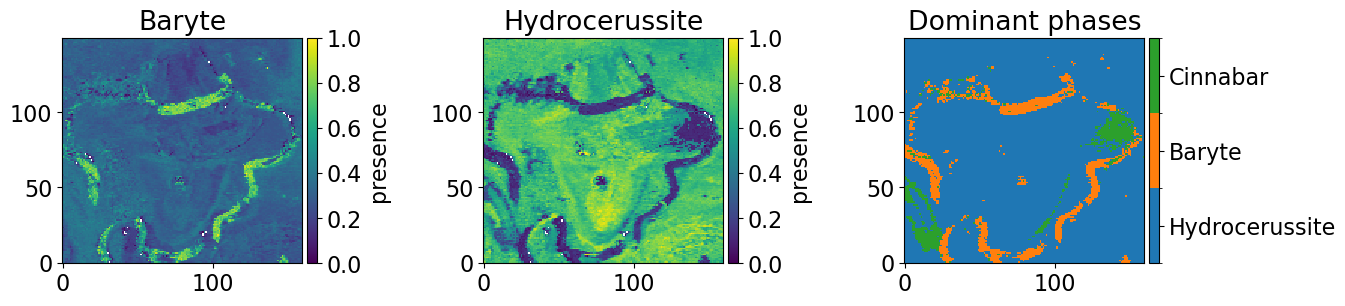

In [29]:
%matplotlib inline
rcParams['font.size'] = 16
position_colorbar = [1.02, 0, 0.04, 1]

### Select the area ###

# All the scan
x_min, x_max = 0, data.shape[1] - 1
y_min, y_max = 0, data.shape[0] - 1

### Angelo ###

# Selected area (gold)
#x_min, x_max = 0, 139
#y_min, y_max = 70, 149

###

area_sel = (x_max - x_min + 1) * (y_max - y_min + 1)
area_scan = data.shape[0] * data.shape[1]
print(f'Area: {x_max - x_min + 1} * {y_max - y_min + 1} = {area_sel}')

fig, axs = subplots(1, 3, figsize = (12, 5))
fig.tight_layout(w_pad = 5)

for i in [0, 1]:
    ax = axs[i]
    im = ax.imshow(presence_phases_sel[i, ...], interpolation = 'none', vmin = 0, vmax = 1)
    settings_plot(im, ax, None, None, None, None, position_colorbar, 'presence')
    if not (area_sel == area_scan):
        ax.plot(
            [x_min, x_min, x_max, x_max, x_min],
            [y_min, y_max, y_max, y_min, y_min],
            ls = '--', c = 'tab:red', lw = 2
        )
    ax.set_title(phases_sel[i].label)

ax = axs[2]
cmap_chosen = get_cmap('tab10')
norm_chosen = BoundaryNorm(arange(-0.5, len(gm.phases) + 0.5, 1), len(gm.phases))
im = imshow(gm.selected(), cmap = cmap_chosen, norm = norm_chosen, interpolation = 'none')
if not (area_sel == area_scan):
    ax.plot(
        [x_min, x_min, x_max, x_max, x_min],
        [y_min, y_max, y_max, y_min, y_min],
        ls = '--', c = 'black', lw = 2
    )
cbar = colorbar(im, ax = ax, cax = ax.inset_axes(position_colorbar))
cbar.set_ticks(range(0, len(gm.phases)))
cbar.set_ticklabels([p.label for p in gm.phases])
ax.set_title('Dominant phases')

savefig(f'{path_figures}selected_area.png', bbox_inches = 'tight', dpi = 200)
show()

### Thresholds
Choose thresholds for the presence of the two phases.
The program will select pixels where the two phases are between given threshold values.

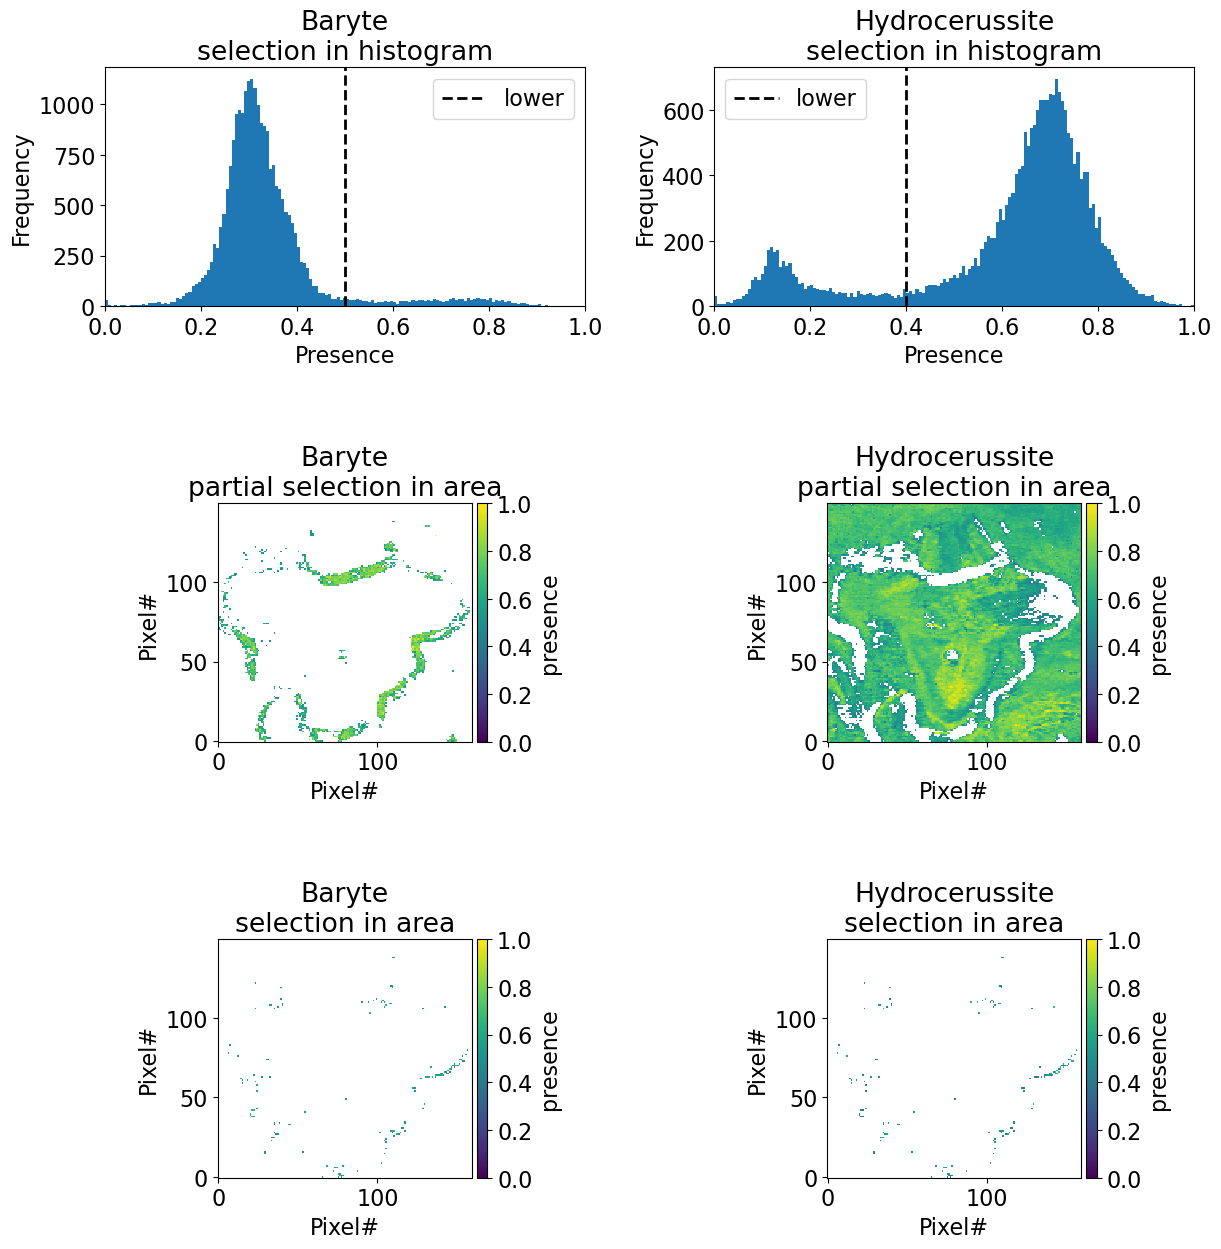

These thresholds select 145 pixels.


In [77]:
%matplotlib inline
rcParams['font.size'] = 16

threshold_reference = {'low': 0.5, 'high': None}
threshold_analysis = {'low': 0.4, 'high': None}
# Lower and upper threshold. You can set as None each threshold to ignore it.


###


### Find selected pixels ###
thresholds = [threshold_reference, threshold_analysis]

indices_area = zeros(data.shape[:2], bool)
indices_good_partial = zeros([2] + list(data.shape[:2]), bool)
indices_good = zeros(data.shape[:2], bool)
for x in range(data.shape[1]):
    for y in range(data.shape[0]):
        if ((x >= x_min) and (x <= x_max) and (y >= y_min) and (y <= y_max)):
            indices_area[y, x] = True
            for i in [0, 1]:
                if (
                    ((thresholds[i]['low'] is None) or (presence_phases_sel[i, y, x] >= thresholds[i]['low']))  and
                    ((thresholds[i]['high'] is None) or (presence_phases_sel[i, y, x] <= thresholds[i]['high']))
                ):
                    indices_good_partial[i, y, x] = True
            if (indices_good_partial[0, y, x] and indices_good_partial[1, y, x]):
                indices_good[y, x] = True

### Plots ###
n_rows = 3
fig, axs = subplots(n_rows, 2, figsize = (12, 4 * n_rows))
fig.tight_layout(h_pad = 7, w_pad = 3)

# Histograms and thresholds
for i, threshold in enumerate(thresholds):
    ax = axs[0, i]
    ax.hist(presence_phases_sel[i, indices_area].flatten(), bins = 'sqrt') # 'sqrt' 'doane'
    if (threshold['low'] is not None):
        ax.axvline(threshold['low'], c = 'black', ls = '--', lw = 2, label = 'lower')
    if (threshold['high'] is not None):
        ax.axvline(threshold['high'], c = 'black', ls = '-', lw = 2, label = 'upper')
    if (threshold['low'] is not None or threshold['high'] is not None):
        ax.legend()
    ax.set_xlim(0, 1)
    ax.set_xlabel('Presence')
    ax.set_ylabel('Frequency')
    ax.set_title(f'{phases_sel[i].label}\nselection in histogram')

# Partial selection of area for each phase
for i in [0, 1]:
    ax = axs[1, i]
    matrix_to_show = presence_phases_sel[i].copy()
    matrix_to_show[~indices_good_partial[i]] = None
    im = ax.imshow(matrix_to_show, interpolation = 'none', vmin = 0, vmax = 1)
    settings_plot(im, ax, x_min, x_max, y_min, y_max, position_colorbar, 'presence')
    ax.set_xlabel(r'Pixel#')
    ax.set_ylabel(r'Pixel#')
    ax.set_title(f'{phases_sel[i].label}\npartial selection in area')

# Total selection of area for each phase
for i in [0, 1]:
    ax = axs[2, i]
    matrix_to_show = presence_phases_sel[i].copy()
    matrix_to_show[~indices_good] = None
    im = ax.imshow(matrix_to_show, interpolation = 'none', vmin = 0, vmax = 1)
    settings_plot(im, ax, x_min, x_max, y_min, y_max, position_colorbar, 'presence')
    ax.set_xlabel(r'Pixel#')
    ax.set_ylabel(r'Pixel#')
    ax.set_title(f'{phases_sel[i].label}\nselection in area')

savefig(f'{path_figures}selection.png', bbox_inches = 'tight', dpi = 300)
show()
print(f'These thresholds select {indices_good.sum()} pixels.')

# Calibration

In [78]:
%%time

beta_adjustment = 0 # adjustment of beta, in degrees

print('Creating map...')
gm_stratigraphy = GammaMap_MultiPhases().from_data(
    data, phases_sel, indices_sel = indices_good, sigma = sigma, clean_peaks = sigma,
    min_theta = min_theta, max_theta = max_theta, min_intensity = min_intensity, first_n_peaks = first_n_peaks, distance_merge = distance_merge
)
if (beta_adjustment):
    for e in gm_stratigraphy:
        e.opt[e.n_phases + 1] += beta_adjustment
print('Done.\n')

print('Fit...')
gm_stratigraphy = gm_stratigraphy.search()
print('Done.\n')

# Calculate calibration differences
calibration_a_reference = gm_stratigraphy.opt()[..., 0]
calibration_a_analysis = gm_stratigraphy.opt()[..., 1]
calibration_s = gm_stratigraphy.opt()[..., gm_stratigraphy.n_phases]

calibration_a_reference[~indices_good] = None
calibration_a_analysis[~indices_good] = None
calibration_s[~indices_good] = None

calibration_a_diff = calibration_a_analysis - calibration_a_reference
a_diff_max = nanmax(absolute(calibration_a_diff))
a_diff_min = - a_diff_max

Da = channel_distance * calibration_a_diff
Da_min = channel_distance * a_diff_min
Da_max = channel_distance * a_diff_max

Dy = Dy_from_Da(Da, gm_stratigraphy.beta())
Dy_max = nanmax(absolute(Dy))
Dy_min = - Dy_max

Dz = Dz_from_Da(Da, angle_incidence, gm_stratigraphy.beta())
Dz_max = nanmax(absolute(Dz))
Dz_min = - Dz_max

Creating map...
Done.

Fit...
Using 8 CPUs
Done.

CPU times: user 163 ms, sys: 25.1 ms, total: 188 ms
Wall time: 300 ms


# View results

### Exploration of the area

The two histogram show the distribution of depth difference $\Delta z$ for the selected pixels.
The second one shows only a part of the pixels. Specifically, pixels where $\Delta z$ is between the two quantiles chosen with `quantiles_for_visualization`.

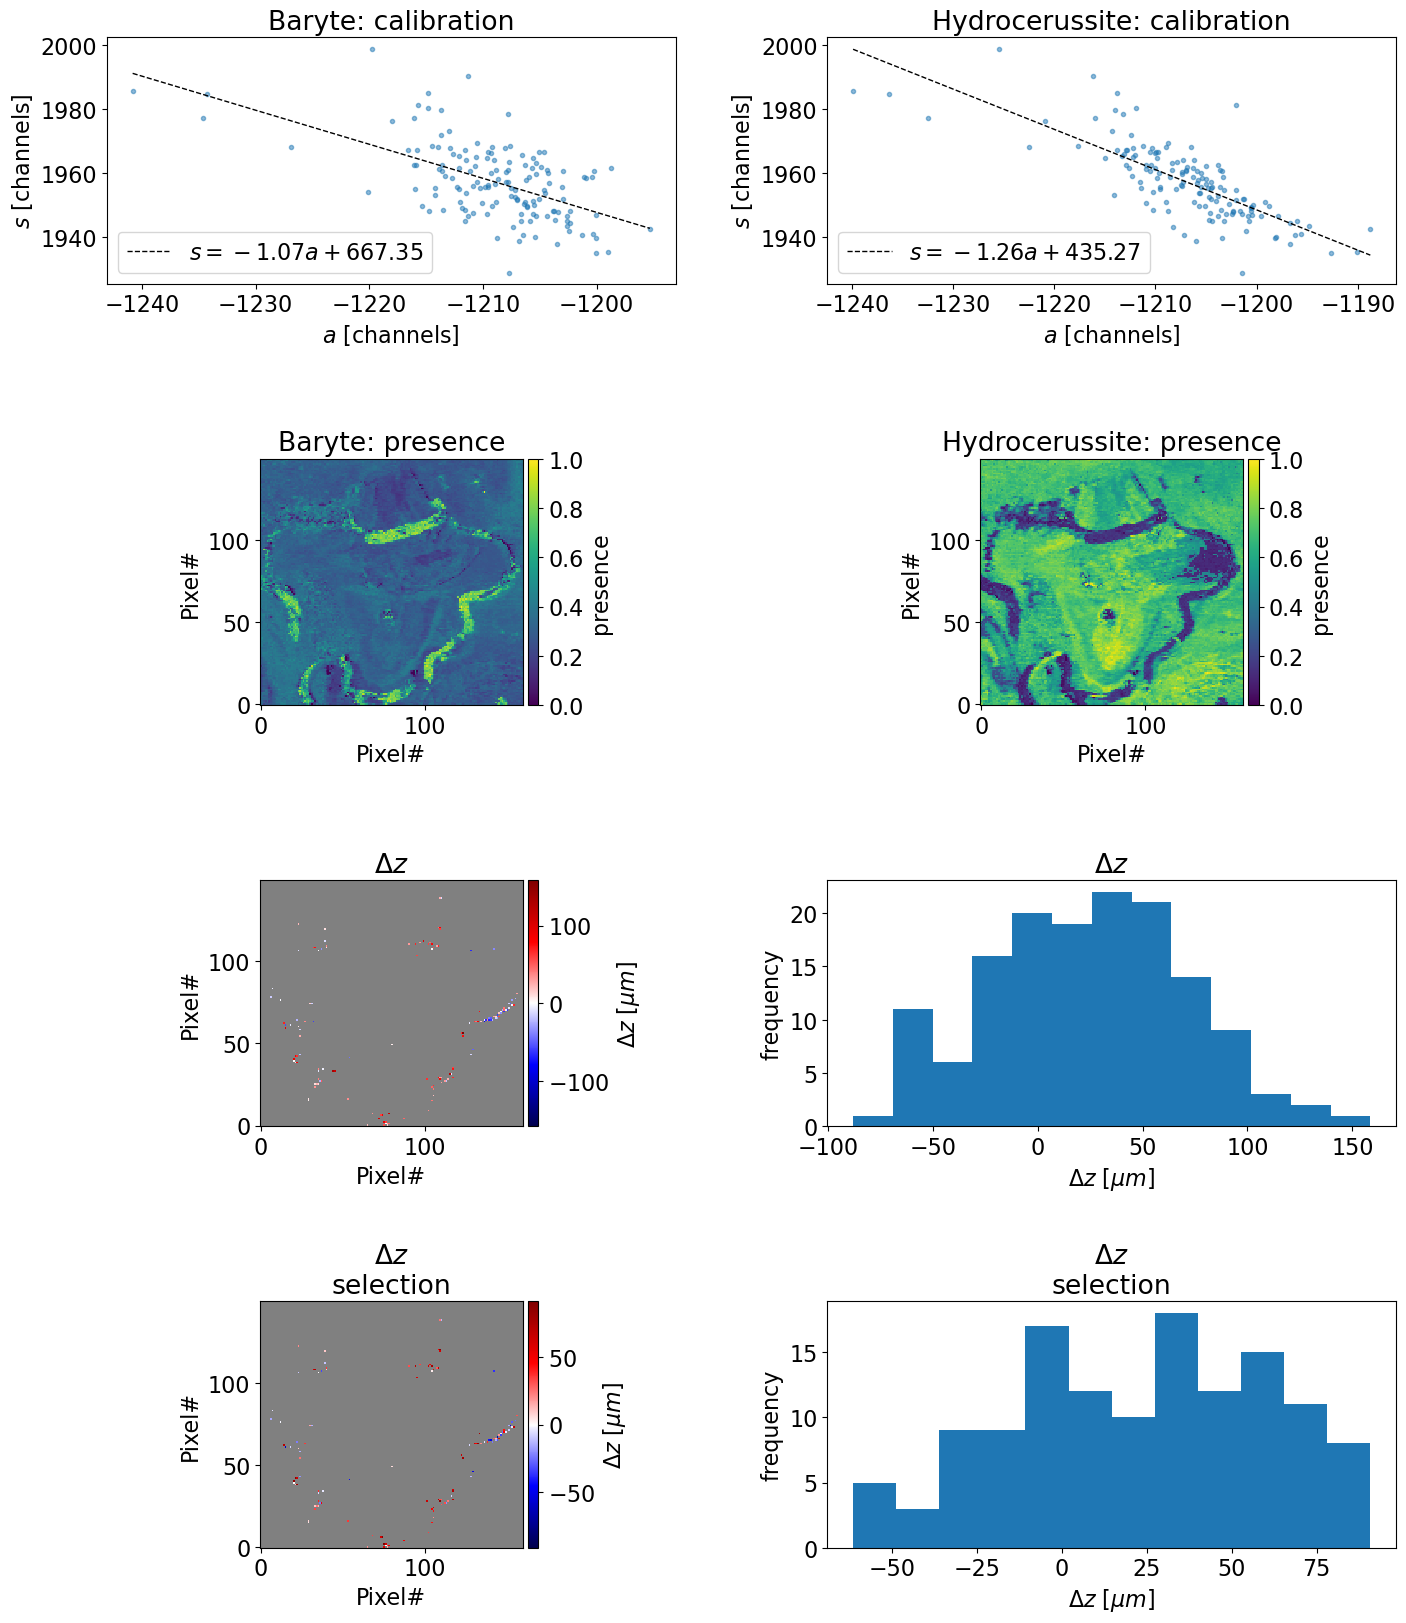

In [80]:
%matplotlib inline
rcParams['font.size'] = 16
log_y_scale = False

position_colorbar = [1.02, 0, 0.04, 1]

quantiles_for_visualization = [0.05, 0.95]
#quantiles_for_visualization = [0, 1]

###

cmap_seismic = get_cmap('seismic').copy()
cmap_seismic.set_bad(color = 'grey')

n_rows = 4
fig, axs = subplots(n_rows, 2, figsize = (14, 4 * n_rows))
fig.tight_layout(h_pad = 6, w_pad = 4)

ax = axs[0, 0]
lin_a = linspace(nanmin(calibration_a_reference), nanmax(calibration_a_reference), 10)
fit_param, fit_var = curve_fit(f_linear, calibration_a_reference[indices_good], calibration_s[indices_good])
ax.plot(calibration_a_reference.flatten(), calibration_s.flatten(), '.', alpha = 0.5)
ax.plot(lin_a, f_linear(lin_a, *fit_param), ls = '--', lw = 1, c = 'black', label = f'$s = {fit_param[0]:.2f} a {fit_param[1]:+.2f}$')
ax.legend()
ax.set_xlabel(r'$a$ [channels]')
ax.set_ylabel(r'$s$ [channels]')
ax.set_title(f'{phase_reference.label}: calibration')

ax = axs[0, 1]
lin_a = linspace(nanmin(calibration_a_analysis), nanmax(calibration_a_analysis), 10)
fit_param, fit_var = curve_fit(f_linear, calibration_a_analysis[indices_good], calibration_s[indices_good])
ax.plot(calibration_a_analysis.flatten(), calibration_s.flatten(), '.', alpha = 0.5)
ax.plot(lin_a, f_linear(lin_a, *fit_param), ls = '--', lw = 1, c = 'black', label = f'$s = {fit_param[0]:.2f} a {fit_param[1]:+.2f}$')
ax.legend()
ax.set_xlabel(r'$a$ [channels]')
ax.set_ylabel(r'$s$ [channels]')
ax.set_title(f'{phase_analysis.label}: calibration')

for i in [0, 1]:
    ax = axs[1, i]
    im = ax.imshow(presence_phases_sel[i], interpolation = 'none', vmin = 0, vmax = 1)
    settings_plot(im, ax, x_min, x_max, y_min, y_max, position_colorbar, 'presence')
    ax.set_xlabel(r'Pixel#')
    ax.set_ylabel(r'Pixel#')
    ax.set_title(phases_sel[i].label + ': presence')

### Map and histogram ###
ax = axs[2, 0]
im = ax.imshow(Dz, interpolation = 'none', vmin = Dz_min, vmax = Dz_max, cmap = cmap_seismic)
settings_plot(im, ax, x_min, x_max, y_min, y_max, position_colorbar, r'$\Delta z$ $[\mu m]$', powerlimits = (-3, 3))
ax.set_xlabel(r'Pixel#')
ax.set_ylabel(r'Pixel#')
ax.set_title(r'$\Delta z$')

ax = axs[2, 1]
ax.hist(Dz.flatten(), bins = 'sqrt') # 'sqrt' 'doane'
if log_y_scale:
    ax.set_yscale('log')
ax.set_xlabel(r'$\Delta z$ $[\mu m]$')
ax.set_ylabel('frequency')
ax.set_title(r'$\Delta z$')

### Map and histogram after selecting with quantile ###
Dz_sel_bounds = nanquantile(Dz, quantiles_for_visualization)
Dz_sel = Dz.copy()
Dz_sel[(Dz_sel < Dz_sel_bounds[0]) | (Dz_sel > Dz_sel_bounds[1])] = nan
Dz_sel_max = nanmax(absolute(Dz_sel))
Dz_sel_min = - Dz_sel_max

ax = axs[3, 0]
im = ax.imshow(Dz_sel, interpolation = 'none', vmin = Dz_sel_min, vmax = Dz_sel_max, cmap = cmap_seismic)
settings_plot(im, ax, x_min, x_max, y_min, y_max, position_colorbar, r'$\Delta z$ $[\mu m]$', powerlimits = (-3, 3))
ax.set_xlabel(r'Pixel#')
ax.set_ylabel(r'Pixel#')
ax.set_title(r'$\Delta z$' + '\nselection')

ax = axs[3, 1]
ax.hist(Dz_sel.flatten(), bins = 'sqrt') # 'sqrt' 'doane'
if log_y_scale:
    ax.set_yscale('log')
ax.set_xlabel(r'$\Delta z$ $[\mu m]$')
ax.set_ylabel('frequency')
ax.set_title(r'$\Delta z$' + '\nselection')

savefig(f'{path_figures}explore_area.png', bbox_inches = 'tight', dpi = 300)
show()

### Check a point

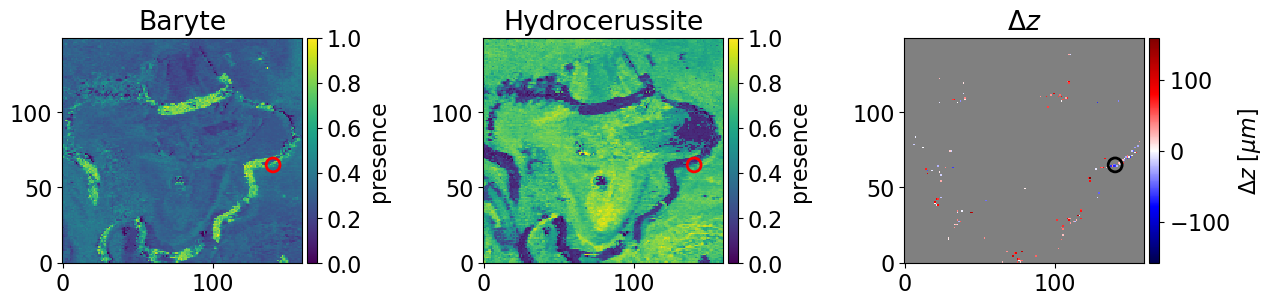

Delta z = -51.725 micron


In [82]:
%matplotlib inline
rcParams['font.size'] = 16
position_colorbar = [1.02, 0, 0.04, 1]

### Angelo ###
#x, y = 118, 45 # Cinnabar and hydrocerussite (positive value)
#x, y = 137, 48 # Cinnabar and hydrocerussite (negative value)
#x, y = 75, 83 # Lead-tin yellow and hydrocerussite
#x, y = 113, 131 # Gold and hydrocerussite

### Profilo ###
#x, y = 145, 17 # Cinnabar and hydrocerussite
#x, y = 95, 75 # Lazurite and hydrocerussite

### Cappello giallo ###
#x, y = 10, 14 # Cinnabar and hydrocerussite (positive value)
#x, y = 13, 20 # Cinnabar and hydrocerussite (negative value)
#x, y = 75, 2 # Barite and hydrocerussite (positive value)
x, y = 140, 65 # Barite and hydrocerussite (negative value)

###

fig, axs = subplots(1, 3, figsize = (12, 4)) # rows, columns
fig.tight_layout(h_pad = 4, w_pad = 5)

for i in [0, 1]:
    ax = axs[i]
    matrix_plot = presence_phases_sel[i, ...]
    if set_nan_as_0:
        matrix_plot[isnan(matrix_plot)] = 0
    ax.scatter(x, y, s = 100, lw = 2, marker = 'o', edgecolors = 'red', facecolors = 'none')
    im = ax.imshow(matrix_plot, interpolation = 'none', cmap = cmap_viridis, vmin = 0, vmax = 1)
    settings_plot(im, ax, x_min, x_max, y_min, y_max, position_colorbar, 'presence')
    #cbar = colorbar(im, ax = ax, cax = ax.inset_axes([1.03, 0, 0.04, 1]))
    #cbar.set_label('presence')
    ax.set_title(phases_sel[i].label)

ax = axs[2]
im = ax.imshow(Dz, interpolation = 'none', vmin = Dz_min, vmax = Dz_max, cmap = cmap_seismic)
ax.scatter(x, y, s = 100, lw = 2, marker = 'o', edgecolors = 'black', facecolors = 'none')
settings_plot(im, ax, x_min, x_max, y_min, y_max, position_colorbar, r'$\Delta z$ $[\mu m]$', powerlimits = (-3, 3))
ax.set_title(f'$\Delta z$')

savefig(f'{path_figures}explore_pixel_{x}_{y}__map.png', bbox_inches = 'tight', dpi = 300)
show()

if (~indices_good[y][x]):
    print(f'Pixel {(x, y)} does not satisfy the given conditions about phase presence.')
else:
    print(f'Delta z = {Dz[y, x] :.3f} micron')

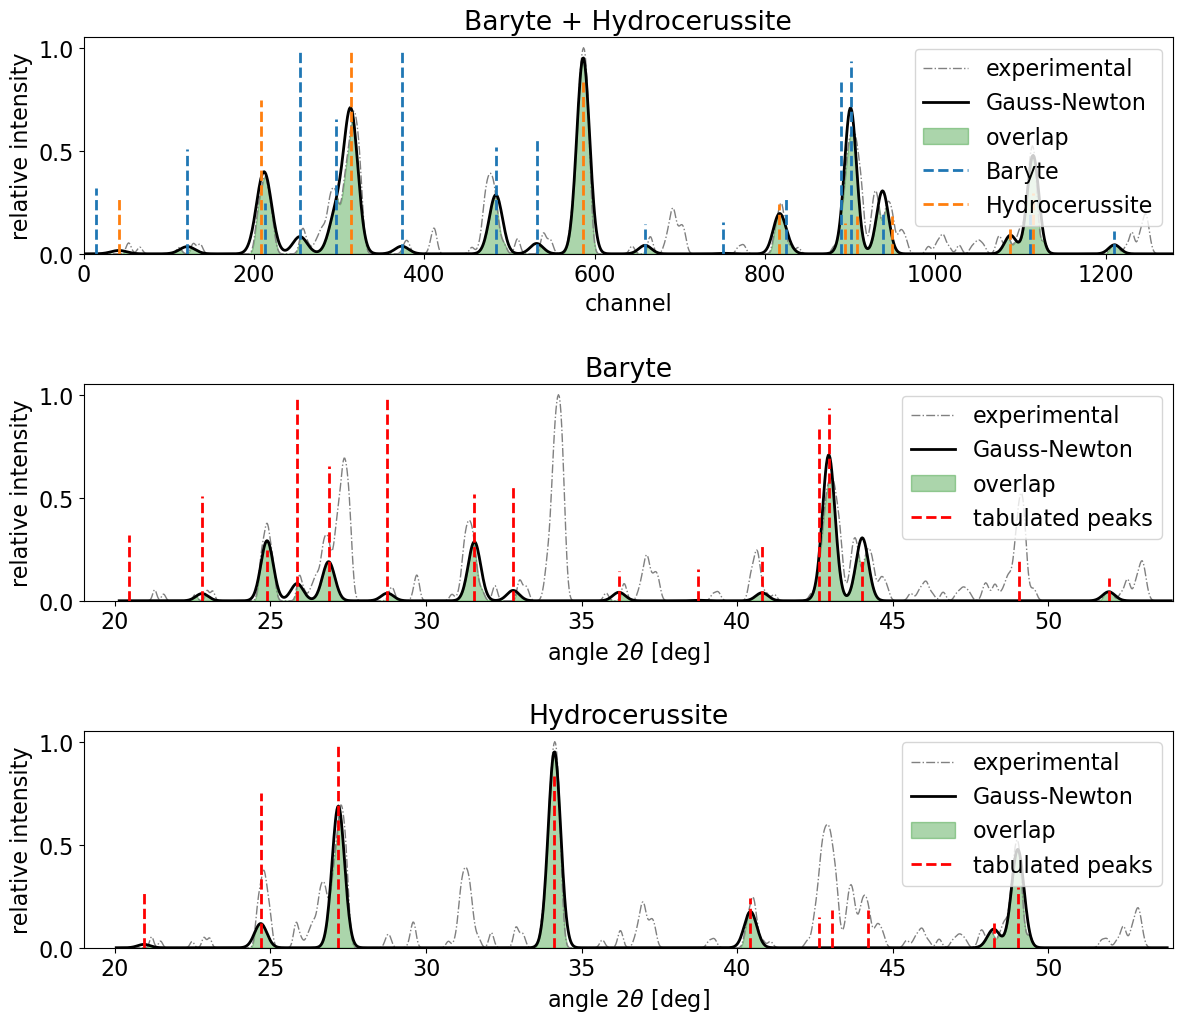

x, y = (140, 65)
a1 = -1200.94, a2 = -1205.40, s = 1958.36, beta = 51.66
Delta a = -4.45 channels = -222.634 micron
Delta y = -283.83 micron (along the incident direction)
Delta z = -51.72 micron (along the direction orthogonal to the sample surface)


In [83]:
%matplotlib inline
rcParams['font.size'] = 16

fig, axs = subplots(3, 1, figsize = (12, 10))
fig.tight_layout(h_pad = 4, w_pad = 4)

gn2 = gm_stratigraphy.get_pixel(x, y)

ax = axs[0]
sca(ax)
ax.plot(gn2.channel, gn2.intensity, c = 'grey', ls = '-.', lw = 1, label = 'experimental')
ax.plot(gn2.channel, gn2.z(), c = 'black', ls = '-', lw = 2, label = 'Gauss-Newton')
ax.fill_between(gn2.channel, gn2.overlap(), color = 'g', alpha = 0.33, label = 'overlap')
for idx, color_label in enumerate(['tab:blue', 'tab:orange']):
    gn2.plot_phase(
        idx,
        x_axis_is_channel = True,
        calibration_function_theta_to_channel = gn2.fce_calibration_inverse,
        calibration_parameters = (gn2.opt[idx], gn2.opt[2], gn2.opt[3]),
        color = color_label, lw = 2, alpha = 1, label = gn2.phases[idx].label
    )

ax.legend(frameon = True, loc = 'upper right')

ax.set_xlim(*gn2.channel[[0, -1]])
ax.set_ylim(0, 1.05)
ax.set_xlabel(r'channel')
ax.set_ylabel(r'relative intensity')
ax.set_title(gn2.label)

for idx in [0, 1]:
    ax = axs[idx + 1]
    sca(ax)
    ax.plot(gn2.theta[idx], gn2.intensity, c = 'grey', ls = '-.', lw = 1, label = 'experimental')
    ax.plot(gn2.theta[idx], gn2.z_partial(idx), c = 'black', ls = '-', lw = 2, label = 'Gauss-Newton')
    ax.fill_between(gn2.theta[idx], gn2.overlap_partial(idx), color = 'g', alpha = 0.33, label = 'overlap')
    gn2.plot_phase(idx, lw = 2, alpha = 1, label = 'tabulated peaks')
    ax.legend(frameon = True, loc = 'upper right')
    
    ax.set_xlim(min_theta - 1, max_theta + 1)
    ax.set_ylim(0, 1.05)
    ax.set_xlabel(r'angle $2\theta$ [deg]')
    ax.set_ylabel(r'relative intensity')
    ax.set_title(gn2.phases[idx].label)
savefig(f'{path_figures}explore_pixel_{x}_{y}__fit.png', bbox_inches = 'tight', dpi = 300)
show()

print(f'x, y = {x, y}')
print(f'a1 = {gn2.opt[0]:.2f}, a2 = {gn2.opt[1]:.2f}, s = {gn2.opt[2]:.2f}, beta = {gn2.opt[3]:.2f}')
print(f'Delta a = {calibration_a_diff[y, x] :.2f} channels = {Da[y, x] :.3f} micron')
print(f'Delta y = {Dy[y, x] :.2f} micron (along the incident direction)')
print(f'Delta z = {Dz[y, x] :.2f} micron (along the direction orthogonal to the sample surface)')

### Calculation of fraction of elements for a given phase

In [14]:
lazurite['_chemical_formula_sum']

'Al2.97 Ca0.8 Mg0.36 Na3.12 O15.12 S Si3.03'

In [15]:
arr_fraction_atom = array([2.97, 0.8, 0.36, 3.12, 15.12, 1, 3.03])
arr_fraction_atom

array([ 2.97,  0.8 ,  0.36,  3.12, 15.12,  1.  ,  3.03])

In [16]:
arr_atomic_weight = array([26.98, 40.08, 24.30, 22.99, 16, 32.06, 28.08])
arr_atomic_weight

array([26.98, 40.08, 24.3 , 22.99, 16.  , 32.06, 28.08])

In [17]:
arr_mass_fraction = arr_fraction_atom * arr_atomic_weight
arr_mass_fraction

array([ 80.1306,  32.064 ,   8.748 ,  71.7288, 241.92  ,  32.06  ,
        85.0824])

In [22]:
from numpy import printoptions

with printoptions(precision = 3):
    print(arr_mass_fraction / arr_mass_fraction.sum())

[0.145 0.058 0.016 0.13  0.438 0.058 0.154]


In [23]:
print(arr_mass_fraction / arr_mass_fraction.sum())

[0.14523417 0.05811498 0.01585547 0.13000617 0.43847232 0.05810773
 0.15420915]
